# Linear Regression

Univariate and multivariate linear regression with and without the use of categorical variables (e.g. soil type) and interactions.

In this exercise we will improve the readings of the FeildScout hand-held soil moisture sensor. An experiment was conduted in the KSU Soil Water Processes lab to collect obsevations in containers with packed soil and carefully measured soil moisture. 

The experiment consisted of multiple soil moisture contents for a total of four contrasting soil textures (silt loam, silty clay, clay loam, and sand), with the aim of generating a universal csutom model that converts period average (the raw varaible measured by the sensor) into volumetric water content (volume of water per unit volume of soil).


In [298]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.graphics.api import qqplot


In [286]:
# Load data
df = pd.read_csv('../datasets/soil_moisture_sensor_calibration_data.csv')
df.head()


,site,soil_texture,vwc_sensor,period,bulk_density,vwc_obs
0,Moundridge_bottomslope,loam,1.70,2040,1.34,0.023
1,Moundridge_bottomslope,loam,14.90,2295,1.30,0.149
2,Moundridge_bottomslope,loam,14.40,2290,1.18,0.165
3,Moundridge_bottomslope,loam,44.65,2915,1.27,0.316
4,Moundridge_bottomslope,loam,64.00,3315,1.49,0.328


In [287]:
# Unit conversions
df["vwc_sensor"] = df["vwc_sensor"]/100 # from percent to fraction to match obs
df["period"] = df["period"] /1000 # from microseconds to milliseconds


In [288]:
# Sort dataframe by the independent variable period
df.sort_values(by="period", inplace=True)
df.head()


,site,soil_texture,vwc_sensor,period,bulk_density,vwc_obs
31,Sand,sand,0.0060,2.03,1.71,0.002
32,Sand,sand,0.0145,2.03,1.70,0.003
7,Moundridge_upslope_subsurf,silty clay,0.0120,2.03,1.29,0.013
0,Moundridge_bottomslope,loam,0.0170,2.04,1.34,0.023
16,Moundridge_upslope_surf,silty clay loam,0.0195,2.04,1.35,0.025


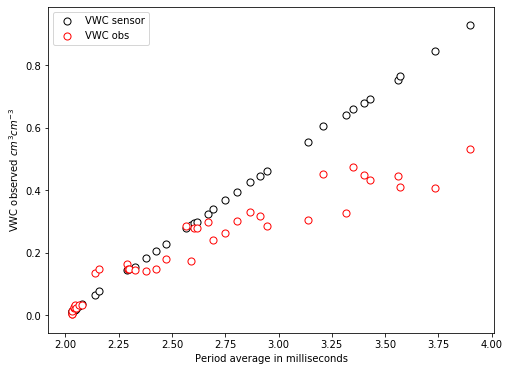

In [289]:
# Plot sensor and observed data
plt.figure(figsize=(8,6))
plt.scatter(df["period"],df['vwc_sensor'], s=50, facecolor='w', edgecolor='k')
plt.scatter(df["period"], df["vwc_obs"], s=50, facecolor='w', edgecolor='r')
plt.xlabel('Period average in milliseconds')
plt.ylabel('VWC observed $cm^3 cm^{-3}$')
plt.legend(['VWC sensor','VWC obs'])
plt.show()


The problem is clear, typical volumetric water contents for mineral soils (opposed to organic soils) have a maximum value of 0.5 cm$^3$ cm$^{-3}$, which is approximately the pore space of the soil. The soil moisture sensors in question with its factory calibration returns values of volumetric water content much higher than usual porosity values. This means that the factory calibration to convert period average into volumetric water content is not adequate for the soils tested in this experiment.

Our goal is to find a better model. This will also imply that when we use this sensor we need to ignore the readings in volumetric water content and we need to record the raw period average readings for posterior trasnlation using our custom model.


## Linear model

THe simplest and easiest model to start our linear regression exercise

In [290]:
# Model as a function of period
formula = 'vwc_obs ~ period'
lm = ols(formula, data=df).fit()
lm.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                vwc_obs   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     359.2
Date:                Wed, 29 Apr 2020   Prob (F-statistic):           1.22e-20
Time:                        11:05:26   Log-Likelihood:                 64.186
No. Observations:                  39   AIC:                            -124.4
Df Residuals:                      37   BIC:                            -121.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4786      0.038    -12.597      0.000      -0.556      -0.402
period         0.2649      0.014     18.953      0.000       0.237       0.293
==============================================================================
Omnibus:                        2.321   Durbin-Watson:                   1.397
Prob(Omnibus):                  0.313   Jarque-Bera (JB):                1.311
Skew:                           0.064   Prob(JB):                        0.519
Kurtosis:                       2.111   Cond. No.                         15.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Quadratic model

Despite its name, linear regression can be used to fit non-linear functions. A linear regression model is linear in the model parameters, not necessarily in the predictors.

In [291]:
# Quadratic calibration model
formula = 'vwc_obs ~ period + I(period ** 2)'
lm_quadratic = ols(formula, data=df).fit()
lm_quadratic.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                vwc_obs   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     272.8
Date:                Wed, 29 Apr 2020   Prob (F-statistic):           1.78e-22
Time:                        11:05:27   Log-Likelihood:                 72.204
No. Observations:                  39   AIC:                            -138.4
Df Residuals:                      36   BIC:                            -133.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.2276      0.178     -6.904      0.000      -1.588      -0.867
period             0.8183      0.130      6.303      0.000       0.555       1.082
I(period ** 2)    -0.0980      0.023     -4.279      0.000      -0.144      -0.052
==============================================================================
Omnibus:                        0.773   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.680   Jarque-Bera (JB):                0.756
Skew:                           0.063   Prob(JB):                        0.685
Kurtosis:                       2.330   Cond. No.                         297.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Linear model with categorical term

You can pass a varaible as a categorical variables using the `C()` notation, for instance: `C(soil_texture)`. 

If you previously converted the variable to categorical using pandas `pd.Categorical()`, then just call the variable in the formula directly, for instance: `vwc_obs ~ period + soil_texture`


In [292]:
# Linear calibration model including soil texture as a categorical
formula = 'vwc_obs ~ period + C(soil_texture)'
lm_with_cat = ols(formula, data=df).fit()
lm_with_cat.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                vwc_obs   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     86.19
Date:                Wed, 29 Apr 2020   Prob (F-statistic):           5.80e-18
Time:                        11:05:28   Log-Likelihood:                 69.494
No. Observations:                  39   AIC:                            -127.0
Df Residuals:                      33   BIC:                            -117.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -0.5134      0.042    -12.294      0.000      -0.598      -0.428
C(soil_texture)[T.sand]                0.0431      0.024      1.813      0.079      -0.005       0.092
C(soil_texture)[T.silt loam]           0.0185      0.023      0.804      0.427      -0.028       0.065
C(soil_texture)[T.silty clay]         -0.0187      0.023     -0.816      0.420      -0.065       0.028
C(soil_texture)[T.silty clay loam]    -0.0171      0.023     -0.747      0.460      -0.064       0.030
period                                 0.2760      0.014     20.378      0.000       0.248       0.304
==============================================================================
Omnibus:                        3.842   Durbin-Watson:                   1.292
Prob(Omnibus):                  0.146   Jarque-Bera (JB):                3.512
Skew:                          -0.722   Prob(JB):                        0.173
Kurtosis:                       2.724   Cond. No.                         20.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Linear model with an interaction term

In [293]:
# Linear calibration model including soil texture as a categorical
formula = 'vwc_obs ~ period * bulk_density'
lm_with_interactions = ols(formula, data=df).fit()
lm_with_interactions.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                vwc_obs   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     137.8
Date:                Wed, 29 Apr 2020   Prob (F-statistic):           1.92e-19
Time:                        11:05:32   Log-Likelihood:                 67.682
No. Observations:                  39   AIC:                            -127.4
Df Residuals:                      35   BIC:                            -120.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.3098      0.404      0.766      0.449      -0.511       1.131
period                 -0.0860      0.159     -0.540      0.593      -0.410       0.238
bulk_density           -0.5903      0.296     -1.997      0.054      -1.191       0.010
period:bulk_density     0.2629      0.118      2.236      0.032       0.024       0.502
==============================================================================
Omnibus:                        1.347   Durbin-Watson:                   1.748
Prob(Omnibus):                  0.510   Jarque-Bera (JB):                1.262
Skew:                          -0.407   Prob(JB):                        0.532
Kurtosis:                       2.663   Cond. No.                         366.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Selecting a model

Because soil texture was not significant and because bulk desnity is not always available, we will select the quadratic model as a function of period average.


In [294]:
y = lm_quadratic.predict(df["period"])
prstd, iv_l, iv_u = wls_prediction_std(lm_quadratic)


In [295]:
# Annotations
str_rsquared = "Rsquared:" + str(round(lm_quadratic.rsquared, 2))


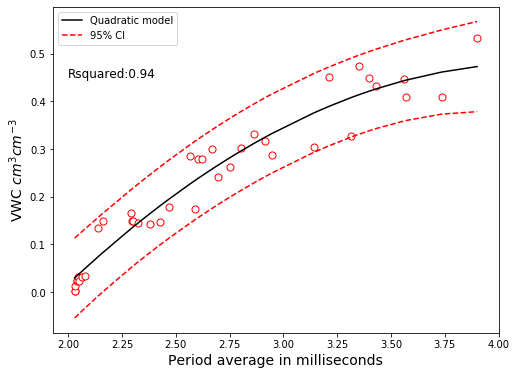

In [296]:
plt.figure(figsize=(8,6))
plt.scatter(df["period"], df["vwc_obs"], s=50, facecolor='w', edgecolor='r')
plt.plot(x,y,'-k')
plt.plot(x, iv_u, 'r--')
plt.plot(x, iv_l, 'r--')

plt.xlabel('Period average in milliseconds', size=14)
plt.ylabel('VWC $cm^3 cm^{-3}$', size=14)
plt.legend(['Quadratic model','95% CI'])
plt.annotate(str_rsquared, (2,0.45), size=12)
plt.show()


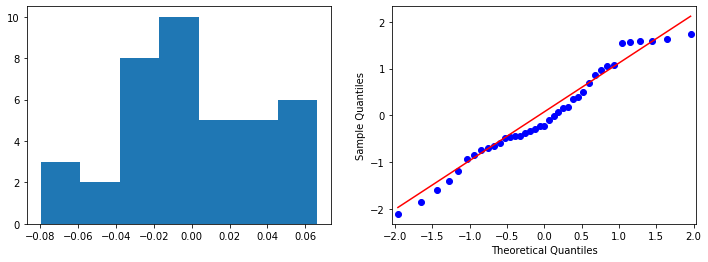

In [313]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(lm_quadratic.resid, bins='sturges')

ax = plt.subplot(1,2,2)
qqplot(lm_quadratic.resid, line='q', ax=ax, fit=True)
plt.show()


In a normal distribution points would fall right on the line. In this case we observe some oscillation, but values don't largely deviate from the line, which suggests that the residuals are normally distributed. Remember that we are dealing with a highly variable porous media, with some error due to the nature of the measurements (some small amount of water evaporates while doing the sensor readings), and our sampling size is rather small, so all things considered this seems to be acceptable. To further test normality we can run a normality test (e.g. Shapiro-Wilk or Kolmogorov-Smirnov).

In [315]:
from scipy import stats
W, pvalue = stats.shapiro(lm_quadratic.resid)

print('Test statistic:', W)
print('p-value for the hypothesis test:', pvalue)


Test statistic: 0.964810848236084
p-value for the hypothesis test: 0.257048100233078


The p-value is greater than 0.05, so it fails to reject the null hypothesis that the residuals are normally distributed.

Note that the table summary alrady has a metric for the normality of residuals using the `Jarque-Bera` test. Below I added the Shapiro-Wilk test since is one of the most common and robust normality tests. The `statsmodels` also has a method for computing the Kolmogorov-Smirnov normality test, look for `statsmodels.stats.diagnostic.kstest_normal`

## References

Yap, B.W. and Sim, C.H., 2011. Comparisons of various types of normality tests. Journal of Statistical Computation and Simulation, 81(12), pp.2141-2155.